In [33]:
import sys
sys.path.insert(0, '../python_scripts')
import json
import glob
import random
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import utils
import importlib
import threading
import meta
import heatmap
#metadata = utils.load("./variables/metadata.p")
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras import callbacks
from keras.preprocessing.image import Iterator
import os
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
import heatmap
remote = callbacks.RemoteMonitor(root='http://localhost:9000')
from shutil import copyfile
from keras.models import load_model
from keras.models import model_from_json
from keras.layers.advanced_activations import LeakyReLU
import time
import h_gen,meta,heatmap
from meta import *
from h_gen import *
from utils import *
import gc 


In [34]:
image_size = [(768, 1216),(1344,2240)]
FOLDER_TRAIN = "./temp_training/resnet/"

In [35]:
SPLIT = 0.8 # For the train/test split
metadata = meta.create_metadata()

['../JSONS/alb_labels.json', '../JSONS/bet_labels.json', '../JSONS/dol_labels.json', '../JSONS/lag_labels.json', '../JSONS/other_labels.json', '../JSONS/shark_labels.json', '../JSONS/yft_labels.json']



In [36]:
for img_size in image_size:
    dim = str(img_size[0])+'_'+str(img_size[1])+'/'
    mk(FOLDER_TRAIN+''+dim)

##### First, let's create the network that will be shared:

##### Here is the final network:

In [37]:
n = [np.zeros((4,4,1,1))]
for i in range(4):
    n[0][i,i,0,0] = 1

In [38]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    nb_filter1, nb_filter2, nb_filter3 = filters
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'


    x = MaxPooling2D((kernel_size, kernel_size), strides=(1,1),
                      border_mode='same', name=conv_name_base + '2b')(input_tensor)

    x = merge([x, input_tensor], mode='max')
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    layer1 = Convolution2D(4, 1, 1, subsample=strides, bias=False, weights=n,
                      name=conv_name_base + '2a')
    x = layer1(input_tensor)
    
    layer2 = MaxPooling2D((kernel_size, kernel_size), strides=(1,1), border_mode='same',
                      name=conv_name_base + '2b')
    x = layer2(x)
    

    layer3 = Convolution2D(4, 1, 1, subsample=strides, bias=False, weights=n,
                             name=conv_name_base + '1')
    
    shortcut = layer3(input_tensor)
    print(layer1.output_shape)
    print(layer2.output_shape)
    print(layer3.output_shape)
    x = merge([x, shortcut], mode='max')
    return x


def ResNet501(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None):
    '''Instantiate the ResNet50 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        inputs_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `tf` dim ordering)
            or `(3, 224, 244)` (with `th` dim ordering).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.

    # Returns
        A Keras model instance.
    '''



    
    img_input = Input(shape=(4,None,None))

    x = ZeroPadding2D((3, 3))(img_input)
    x = MaxPooling2D((7, 7), strides=(2, 2), name='conv1')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = MaxPooling2D((7, 7),strides=(1,1), name='avg_pool')(x)


    model = Model(img_input, x)
    return model

In [39]:
def return_model(pool_branches = [(2,2), (4,4), (5,5), (8,8),(10,10)]):
    nb_input_filters = 1000
    N = 36
    
    img_input = Input(shape=(4,None,None))

    W = []
    for i in range(N):
        if i == 0:
            w = img_input
            W.append(w)
        else:
            #if (i+2,i+2) in pool_branches:
            w = MaxPooling2D(pool_size=(i+1,i+1), strides=(1,1))(img_input)
            W.append(w)

    model = Model(input=img_input, output=W)
    return model

In [40]:
resnet = ResNet501()

(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)


In [41]:
model1 = return_model()

In [42]:
b = Input(shape=(4,1344,2240))
d = resnet(b)
x = model1(d)
final_model = Model(input=b,output=x)

In [43]:
my_matrix = np.zeros((1,4,768,1216))
my_ = np.zeros((1,4,1344,2240))
x_r = int(1344/768)
y_r = int(2240/1216)
print(x_r,x_r)

1 1


In [44]:
#my_matrix[0,0,0,0] = 1
#my_matrix[0,1,100,0] = 1
#my_matrix[0,2,0,300] = 1
#my_matrix[0,3,100,300] = 1
my_[0,0,0,0] = 1
my_[0,1,100*y_r,0] = 1
my_[0,2,0,300*x_r] = 1
my_[0,3,100*y_r,300*x_r] = 1

In [45]:
res = final_model.predict(my_)

(36, 64) (36, 64)


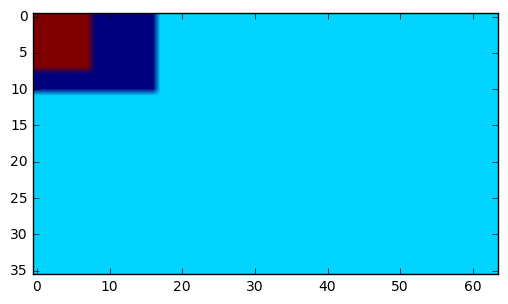

In [46]:
for r in res:
    re = r[0]
    a = re[0]#.reshape(re[0].shape[0]*re[0].shape[1])
    b = re[1]#.reshape(re[0].shape[0]*re[0].shape[1])
    c = re[2]#.reshape(re[0].shape[0]*re[0].shape[1])
    d = re[3]#.reshape(re[0].shape[0]*re[0].shape[1])
    e = np.zeros((re[0].shape[0],re[0].shape[1]))
    no_fish_coord = np.where((a+b+c+d)==0)
    print(e.shape,a.shape)
    inter = np.where(np.multiply(np.multiply(a,b),np.multiply(c,d))==1)
    e[inter]=1
    e[no_fish_coord]=0.5
    left = np.where(e==0)
    e[left]=0.25
    plt.imshow(e)
    plt.show()
    break

##### Let's insert the imageNet weights:

In [50]:
# This function gives the 4 corners of the rectangle in a mask with a size
# different from the image size
def get_4_points(rectangle, height,width, target_height, target_width):
    ratio_y = height/target_height
    ratio_x = width/target_width
    new_x = rectangle["x"]/ratio_x
    new_y = rectangle["y"]/ratio_y
    new_x2 = (rectangle["x"]+rectangle["width"])/ratio_x
    new_y2 = (rectangle["y"]+rectangle["height"])/ratio_y
    result = np.zeros((4,2))
    result[:2,0] = new_x
    result[2:,0] = new_x2
    result[0,1] = new_y
    result[2,1] = new_y
    result[1,1] = new_y2
    result[3,1] = new_y2
    result[:,0].clip(min=0, max=target_width, out=result[:,0])
    result[:,1].clip(min=0, max=target_height, out=result[:,1])
    result = result.astype(int)
    return result
def get_zones(res):
    R = []
    for r in res:
        re = r[0]
        a = re[0]#.reshape(re[0].shape[0]*re[0].shape[1])
        b = re[1]#.reshape(re[0].shape[0]*re[0].shape[1])
        c = re[2]#.reshape(re[0].shape[0]*re[0].shape[1])
        d = re[3]#.reshape(re[0].shape[0]*re[0].shape[1])
        e = np.zeros((re[0].shape[0],re[0].shape[1]))
        no_fish_coord = np.where((a+b+c+d)==0)
        #print(e.shape,a.shape)
        inter = np.where(np.multiply(np.multiply(a,b),np.multiply(c,d))==1)
        e[inter]=1
        e[no_fish_coord]=0.5
        left = np.where(e==0)
        e[no_fish_coord]=0
        e[left]=0.5
        #plt.imshow(e)
        #plt.show()
        R.append(e)
    return R

def mul(res):
    if len(res)==1:
        return res[0]
    return np.multiply(res[0],mul(res[1:]))

def add(res):
    if len(res)==1:
        return res[0]
    return res[0]+add(res[1:])


def get_zones_fishes(res):

    #print(res)
    res = 1-np.array(res)
    e = np.zeros((res[0].shape[0],res[0].shape[1]))
    
    fish_coord = np.where((mul(res)==0))
    #print(e.shape,a.shape)
    addi = add(res)
    no_fish_coord = np.where((addi==len(res)))
    e[no_fish_coord]=0.5
    e[fish_coord]=1
    #plt.imshow(e)
    #plt.show()

    return e
def get_zones_with_rects(list_masks):
    result = []
    for j in range(len(list_masks[0])):
        obj = []
        for i in range(len(list_masks)):
            obj.append(list_masks[i][j])
        #print([o.shape for o in obj])
        result.append(get_zones_fishes(obj))
    return result
                
        


In [51]:
folder = "folder_store_masks/"
utils.mk(folder)
for key, v in tq(list(metadata.items())):
    if v["class"] != "NoF":
        if "rectangles" in v:
            utils.mk(folder + v["filename"])
            list_masks = []
            for rec in v["rectangles"]:
                points = get_4_points(rec, v["height"], v["width"], 1344, 2240)
                matrice = np.zeros((1,4,1344,2240))
                #print(points)
                #plt.imshow(load_img(v["path"], target_size=(1344, 2240)))
                #plt.plot(*zip(*points))
                #plt.show()
                for k in range(4):
                    matrice[0,k,points[k,1],points[k,0]] = 1
                #plt.imshow(matrice[0][0])
                #plt.show()
                out_branches = final_model.predict(matrice)
                #for i in range(len(out_branches)):
                #    plt.imshow(out_branches[i][0][0])
                #    plt.show()
                list_masks.append(get_zones(out_branches))
            if len(list_masks)>1:
                list_masks = [get_zones_with_rects(list_masks)]
            else:
                list_masks = [list_masks]
            print(len(list_masks))
            for mask in list_masks[0]:
                print([x.shape for x in mask])
                for i in range(36):
                    #print(mask[i].shape)
                    one_hot = np.zeros((8,) + (mask[i].shape[1],mask[i].shape[0]))
                    #print(one_hot.shape,np.where(mask[i]==0.5))
                    one_hot[0,np.where(mask[i]==0.5)]=1
                    one_hot[v["code"], np.where(mask[i]==1)]=1
                    utils.save_array(one_hot, folder + v["filename"] + "/" + str(one_hot.shape))
        
                    
    # No fish case
    else:
        print('')
        for i in range(1,36):
            utils.mk(folder + v["filename"])
            one_hot = np.zeros((8,i+28,i))
            one_hot[0,:,:]=1
            utils.save_array(one_hot, folder + v["filename"] + "/" + str(one_hot.shape))
            


1
[(36, 64), (35, 63), (34, 62), (33, 61), (32, 60), (31, 59), (30, 58), (29, 57), (28, 56), (27, 55), (26, 54), (25, 53), (24, 52), (23, 51), (22, 50), (21, 49), (20, 48), (19, 47), (18, 46), (17, 45), (16, 44), (15, 43), (14, 42), (13, 41), (12, 40), (11, 39), (10, 38), (9, 37), (8, 36), (7, 35), (6, 34), (5, 33), (4, 32), (3, 31), (2, 30), (1, 29)]
1
[(36, 64), (35, 63), (34, 62), (33, 61), (32, 60), (31, 59), (30, 58), (29, 57), (28, 56), (27, 55), (26, 54), (25, 53), (24, 52), (23, 51), (22, 50), (21, 49), (20, 48), (19, 47), (18, 46), (17, 45), (16, 44), (15, 43), (14, 42), (13, 41), (12, 40), (11, 39), (10, 38), (9, 37), (8, 36), (7, 35), (6, 34), (5, 33), (4, 32), (3, 31), (2, 30), (1, 29)]
1
[(64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,)]



IndexError: tuple index out of range

In [ ]:
# We need the last weights of the resnet50:
resnet = ResNet50()

In [ ]:
model.layers[2]

In [ ]:
resnet.layers[-1]

In [ ]:
heatmap.insert_weights(resnet.layers[-1], model.layers[2])

In [ ]:
model_file = "models/resnet_mask_training.h5"
mk('models/')

In [ ]:
# we can now save the model.
model.save(model_file)

## Fourth step, training.

In [ ]:
del resnet
gc.collect()

In [ ]:
model_file = "models/resnet_mask_training.h5"
model = load_model(model_file)

In [ ]:
#model.summary()

In [ ]:
model.layers[2].trainable=False

In [ ]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.0, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=adam, sample_weight_mode="temporal")

In [ ]:
train_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size)
test_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size)
history = model.fit_generator(train_gen, samples_per_epoch=2, nb_epoch=150, callbacks=[remote], 
                              verbose=0,validation_data=test_gen, nb_val_samples=2)
# 

In [ ]:
model.layers[2].trainable=True

In [ ]:
sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.0, nesterov=True)
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [ ]:
train_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata,image_size)
test_gen = DiskArrayIterator(2, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size)
history = model.fit_generator(train_gen, samples_per_epoch=2, nb_epoch=25, callbacks=[remote], 
                              verbose=0,validation_data=test_gen, nb_val_samples=2)
# 

In [ ]:
file_trained = "models/fish_detection_trained_1.1.h5"

In [ ]:
model.save(file_trained)

In [ ]:
model = load_model(file_trained)

## Fifth step, display results.

<h1> STATISCAL ANALYSIS OF MEAN_MAX RESULTS </h1>

In [ ]:
Final = []
c = tq(total=100*16)
N = 100
n = 0
for X, Y, W , paths,is_rects in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata,image_size, with_name=True, shuffle=False,debug2=True):
    Z = model.predict(X)   
    n +=1
    if n < N:
        for i in range(16):
            c.update()
            maxs = []
            for j in range(5):
                maxs.append(np.max(Z[j][i]))
            mean_max = np.array(maxs).mean()
            try:
                Final.append([mean_max,is_rects[i]])
            except:
                pass
    else:
        break
import pickle        
pickle.dump( Final, open( "Final.p", "wb" ) )

In [ ]:
Final = pickle.load( open( "Final.p", "rb" ) )

In [ ]:
w_f = []
wo_f = []
for i in range(len(Final)):
    if Final[i][1]:
        w_f.append(Final[i][0])
    else:
        wo_f.append(Final[i][0])
w_f = np.array(w_f) 
wo_f = np.array(wo_f) 
print('LENGTH OF TEST : '+str(len(Final)))
print('mean w_f : '+str(np.array(w_f).mean()))
print('mean wo_f : '+str(np.array(wo_f).mean()))
print('min w_f : '+str(np.array(w_f).min()))
print('min wo_f : '+str(np.array(wo_f).min()))
print('std w_f : '+str(np.array(w_f).std()))
print('std wo_f : '+str(np.array(wo_f).std()))
print('THRESHOLD : '+str(np.array(w_f).mean() - np.array(w_f).std()))

In [ ]:
Z = model.predict(X)

In [ ]:
importlib.reload(htr)

In [ ]:
for i in range(4):
    print(paths[i])
    plt.imshow(load_img(paths[i]))
    plt.show()
    maxs = []
    for j in range(5):
        plt.figure(figsize=(24,24))
        plt.subplot(1,2,1)
        plt.imshow(np.reshape(Y[j][i],mask_size[1]))
        plt.subplot(1,2,2)
        plt.imshow(np.reshape(Z[j][i],mask_size[1]))
        plt.show()
        print("max: ", np.max(Z[j][i]))
        print("min: ", np.min(Z[j][i]))
        maxs.append(np.max(Z[j][i]))
    mean_max = np.array(maxs).mean()
    masks = np.array([np.reshape(Z[j][i],mask_size[1]) for j in range(5)])
    print(masks.shape)
    #rectangles = htr.find_rectangles([masks],mean_max, threshold=100, ranges=(5,20), clip=0.20, debug=True,
    #                    border_conf=[(11,3),(71,10)], batch_size=1, max_fish=10)